# Terrenos vs otro
limpieza al shp de terrenos.
- Identificar los terrenos de casas y apendarlos con terrenos
- Agrupar las geometrias 
- Usar el archivo cruces_limpieza_shp


In [1]:
!pip install geopandas
import geopandas as gpd
import pandas as pd 
import sys
# sys.path.append(r'C:\Users\mfpen\Documents\Repositorios\geoloc2\Detecciondeterrenos')
# from codigos import obtener_curt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 108.6 MB/s eta 0:00:00


In [2]:
def obtener_curt(data:gpd.GeoDataFrame, geom_col:str):
    '''
    (Function)
        Función que recibe un gdf y devuelve el mismo geodata con la clave unica de registro territorial
        en formato latitud(10 dígitos) + longitud(10 dígitos)
    (Parameters)
        - data    : GeoDataFrame al cual se le obtendrán las curt
        - geom_col: Str del nombre de la columna la cual contiene los polígonos 
    
    '''
    def convert_to_dms(coord):
        '''
    (Function)
        Funcion interna que recibe una coordenada y devuelve la misma pero en formato
        str de la forma: grados + minutos + segundos + diezmilesimas de segundo
    (Parameters)
        - coord: Coordenadas del centroide     
    '''
        degrees = int(coord)
        minutes = int((coord - degrees) * 60)
        seconds = int(((coord - degrees) * 60 - minutes) * 60)
        milliseconds = int((((coord - degrees) * 60 - minutes) * 60 - seconds) * 10000)
        return str(abs(degrees)).zfill(2)+str(abs(minutes)).zfill(2)+str(abs(seconds)).zfill(2)+str(abs(milliseconds)).zfill(4)

    data['centroid'] = data[geom_col].to_crs(4326).centroid
    data['lat'] = data['centroid'].y
    data['lon'] = data['centroid'].x
    data['CURT_f'] = data['lat'].apply(convert_to_dms)+data['lon'].apply(convert_to_dms)
    return data.drop(columns=['centroid','lat','lon'])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Usar el de casas original
path_casas = "/content/drive/MyDrive/Geo/Data/geoshaps/Atlacomulco/Rotacion_Atlacomulco/prueba_deteccion_3_rotacion.shp"
# Usar terrenos original
path_terrenos = "/content/drive/MyDrive/Geo/Data/geoshaps/Atlacomulco/atlacomulco_3105/Salidas/Atlacomulco_terrenos.shp"
# Usar chinchetas original
path_chinchetas = "/content/drive/MyDrive/Cruces_predial_otros/Atlacomulco/Bases_salida_limpieza/casas/Atlacomulco_casas_pinesxdenue.shp"

In [5]:
casas = gpd.read_file(path_casas)
terrenos = gpd.read_file(path_terrenos)
pines = gpd.read_file(path_chinchetas)

In [6]:
terrenos.clase_dete.value_counts()

establecimiento    25459
terreno_baldio     24191
casas               1799
Name: clase_dete, dtype: int64

In [7]:
casas['clase_dete'].value_counts()

establecimiento    36247
casas              21329
terreno_baldio       923
en_construccion        3
multivivienda          1
Name: clase_dete, dtype: int64

In [8]:
# Terrenos de casas
new_terrenos = casas[casas['clase_dete']== 'terreno_baldio']
new_terrenos.shape

(923, 5)

In [9]:
terrenos.columns

Index(['clase_dete', 'conf', 'area', 'geometry'], dtype='object')

In [10]:
terrenos=terrenos.set_crs(3857,allow_override=True)
new_terrenos=new_terrenos.set_crs(3857,allow_override=True)
print(terrenos.crs,new_terrenos.crs)

EPSG:3857 EPSG:3857


In [11]:
# Concatenar terrenos de casas a terrenos
terrenos = pd.concat([terrenos.to_crs(3857), new_terrenos.to_crs(3857)])
terrenos.shape

(52372, 5)

In [12]:
# Etiquetar las casas y establecimientos
terrenos.loc[(terrenos['clase_dete']=='casas') | (terrenos['clase_dete']=='establecimiento'), 'con_const'] = 1
terrenos.loc[terrenos.con_const!=1, 'con_const'] = 0
terrenos.loc[(terrenos['clase_dete']=='casas') | (terrenos['clase_dete']=='establecimiento'), 'clase_dete'] = 'terreno_baldio'

In [13]:
terrenos=obtener_curt(terrenos,'geometry')
terrenos.tail(2)

<ipython-input-2-9afc288106d0>:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['centroid'] = data[geom_col].to_crs(4326).centroid


,clase_dete,conf,area,geometry,status,con_const,CURT_f
58448,terreno_baldio,0.56149,601.676858,"POLYGON ((-11103676.268 2244580.136, -11103638...",area_small,0.0,19453434949944450830
58499,terreno_baldio,0.53138,361.006115,"POLYGON ((-11099977.250 2245867.522, -11099959...",correcto,0.0,19461399749942455637


In [14]:
# Revision de duplicados por geometria
terrenos.geometry.value_counts()

POLYGON ((-11129071.433 2257656.199, -11128985...    1
POLYGON ((-11129088.903 2256905.858, -11129003...    1
POLYGON ((-11129007.305 2257309.176, -11128923...    1
POLYGON ((-11128986.788 2257414.498, -11128902...    1
POLYGON ((-11129070.220 2257497.262, -11128981...    1
                                                    ..
POLYGON ((-11105018.221 2245463.815, -11105014...    1
POLYGON ((-11104980.476 2248696.892, -11104937...    1
POLYGON ((-11104974.845 2247641.659, -11104966...    1
POLYGON ((-11104821.000 2245302.890, -11104818...    1
POLYGON ((-11099977.250 2245867.522, -11099959...    1
Name: geometry, Length: 52372, dtype: int64

In [15]:
# Borrar duplicados
terrenos.sort_values('conf',ascending=False,inplace=True)
terrenos.drop_duplicates(subset='geometry',keep='first',inplace=True)
terrenos.tail(2)

,clase_dete,conf,area,geometry,status,con_const,CURT_f
26365,terreno_baldio,0.20002,782.179916,"POLYGON ((-11118878.968 2255709.957, -11118851...",correcto,0.0,19511342599952565529
31275,terreno_baldio,0.20001,694.936771,"POLYGON ((-11112981.674 2243522.117, -11112966...",NaN,1.0,19450241899949459882


In [16]:
pines.columns

Index(['clase_dete', 'conf', 'area', 'angulo', 'Clase', 'umbral', 'n_resize',
       'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'ID_denue',
       'geometry'],
      dtype='object')

In [ ]:
#Eliminar las columnas que traen el concatenado de CLase y solo dejar la columna buena
pines.drop(['Clase1','Clase'],axis=1,inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase_lim,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [ ]:
#La columna de clasificacion de chinchetas debe llamarse Clase, sino cambiar
pines.rename(columns={'Clase_lim':'Clase'},inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [ ]:
#En el caso de ya tener pines vs denue, cambiar el nombre de la columna id a ID_denue
pines.rename(columns={'id':'ID_denue'},inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [17]:
pines.Clase.value_counts()

establecimiento_google       954
tiendas_1                    929
0                            431
restaurante_google           372
establecimientos_google      366
educativo                    190
iglesia                       70
a_verdes_1                    46
bar                           35
gas_google                    33
tiendas_2                     32
Hospital                      25
farmacia                      22
establecimientos_2_google     13
Jardin                        11
sitios_interes_google         10
entretenimiento_google         7
tiendas_3                      7
a_verdes_2                     6
cafe                           3
poli                           3
hospedaje_google               3
salud_google                   2
cine                           1
bancos_google                  1
cultural_3                     1
golf                           1
Name: Clase, dtype: int64

In [18]:
pines.drop(['clase_dete'],axis=1,inplace=True)

In [19]:
pines.columns

Index(['conf', 'area', 'angulo', 'Clase', 'umbral', 'n_resize', 'tipoCenCom',
       'tipo_asent', 'nombre_act', 'clee', 'ID_denue', 'geometry'],
      dtype='object')

In [20]:
pines.rename(columns={'conf':'conf_pin','area':'area_pin'},inplace=True)

In [21]:
# Areas verdes de pines
pines_verdes = pines[(pines['Clase']== 'a_verdes')|(pines['Clase']== 'a_verdes_1') |(pines['Clase']== 'a_verdes_2')]
pines_verdes.shape

(52, 12)

In [22]:
cruce_terrenosxpines = gpd.sjoin(terrenos,pines_verdes)
cruce_terrenosxpines

,clase_dete,conf,area,geometry,status,con_const,CURT_f,index_right,conf_pin,area_pin,angulo,Clase,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue
49001,terreno_baldio,0.68224,6496.104481,"POLYGON ((-11102725.252 2245622.120, -11102646...",NaN,0.0,19460532229944135305,3570,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN
48922,terreno_baldio,0.52891,8389.380996,"POLYGON ((-11102820.103 2245617.117, -11102729...",NaN,0.0,19460540109944161277,3570,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN
13569,terreno_baldio,0.67754,4277.922463,"POLYGON ((-11120452.192 2250276.950, -11120373...",NaN,1.0,19482722299953469666,760,0.93201,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN
49021,terreno_baldio,0.65014,10056.025893,"POLYGON ((-11102699.811 2244037.791, -11102613...",NaN,1.0,19451611589944136240,3571,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN
49100,terreno_baldio,0.42959,7403.633742,"POLYGON ((-11102603.230 2244049.392, -11102526...",NaN,1.0,19451670729944105041,3571,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN
39570,terreno_baldio,0.63650,10699.820132,"POLYGON ((-11109044.402 2252841.751, -11108963...",NaN,1.0,19494620099947369041,3301,0.95425,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN
39403,terreno_baldio,0.62803,11687.572974,"POLYGON ((-11109053.379 2252916.238, -11108973...",NaN,1.0,19494607959947394561,3301,0.95425,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN
40067,terreno_baldio,0.61753,11692.586948,"POLYGON ((-11108800.873 2252928.453, -11108714...",NaN,1.0,19494853569947289421,3302,0.93963,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN
36537,terreno_baldio,0.61141,11149.072186,"POLYGON ((-11110491.434 2251790.316, -11110411...",NaN,1.0,19491414739948236568,3289,0.94922,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN
36538,terreno_baldio,0.57079,8121.634793,"POLYGON ((-11110453.061 2251767.548, -11110366...",NaN,1.0,19491176859948238222,3289,0.94922,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN


In [23]:
cruce_terrenosxpines['PIN_si'] = 1
cruce_terrenosxpines

,clase_dete,conf,area,geometry,status,con_const,CURT_f,index_right,conf_pin,area_pin,angulo,Clase,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,PIN_si
49001,terreno_baldio,0.68224,6496.104481,"POLYGON ((-11102725.252 2245622.120, -11102646...",NaN,0.0,19460532229944135305,3570,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN,1
48922,terreno_baldio,0.52891,8389.380996,"POLYGON ((-11102820.103 2245617.117, -11102729...",NaN,0.0,19460540109944161277,3570,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN,1
13569,terreno_baldio,0.67754,4277.922463,"POLYGON ((-11120452.192 2250276.950, -11120373...",NaN,1.0,19482722299953469666,760,0.93201,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN,1
49021,terreno_baldio,0.65014,10056.025893,"POLYGON ((-11102699.811 2244037.791, -11102613...",NaN,1.0,19451611589944136240,3571,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN,1
49100,terreno_baldio,0.42959,7403.633742,"POLYGON ((-11102603.230 2244049.392, -11102526...",NaN,1.0,19451670729944105041,3571,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN,1
39570,terreno_baldio,0.63650,10699.820132,"POLYGON ((-11109044.402 2252841.751, -11108963...",NaN,1.0,19494620099947369041,3301,0.95425,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN,1
39403,terreno_baldio,0.62803,11687.572974,"POLYGON ((-11109053.379 2252916.238, -11108973...",NaN,1.0,19494607959947394561,3301,0.95425,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN,1
40067,terreno_baldio,0.61753,11692.586948,"POLYGON ((-11108800.873 2252928.453, -11108714...",NaN,1.0,19494853569947289421,3302,0.93963,69.415145,-89.999999,a_verdes_1,0.92,70,NaN,NaN,NaN,NaN,NaN,1
36537,terreno_baldio,0.61141,11149.072186,"POLYGON ((-11110491.434 2251790.316, -11110411...",NaN,1.0,19491414739948236568,3289,0.94922,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN,1
36538,terreno_baldio,0.57079,8121.634793,"POLYGON ((-11110453.061 2251767.548, -11110366...",NaN,1.0,19491176859948238222,3289,0.94922,65.076698,-89.999999,a_verdes_1,0.92,60,NaN,NaN,NaN,NaN,NaN,1


In [24]:
no_cruzanxPines=terrenos[~(terrenos.geometry.isin(cruce_terrenosxpines['geometry']))]
no_cruzanxPines.shape

(52330, 7)

In [25]:
no_cruzanxPines['PIN_si']=0
no_cruzanxPines.tail(2)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,clase_dete,conf,area,geometry,status,con_const,CURT_f,PIN_si
26365,terreno_baldio,0.20002,782.179916,"POLYGON ((-11118878.968 2255709.957, -11118851...",correcto,0.0,19511342599952565529,0
31275,terreno_baldio,0.20001,694.936771,"POLYGON ((-11112981.674 2243522.117, -11112966...",NaN,1.0,19450241899949459882,0


In [26]:
cruce_terrenosxpines.shape, no_cruzanxPines.shape

((42, 20), (52330, 8))

In [27]:
crucexpin=pd.concat([cruce_terrenosxpines,no_cruzanxPines])
crucexpin

,clase_dete,conf,area,geometry,status,con_const,CURT_f,index_right,conf_pin,area_pin,angulo,Clase,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,PIN_si
49001,terreno_baldio,0.68224,6496.104481,"POLYGON ((-11102725.252 2245622.120, -11102646...",NaN,0.0,19460532229944135305,3570.0,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70.0,NaN,NaN,NaN,NaN,NaN,1
48922,terreno_baldio,0.52891,8389.380996,"POLYGON ((-11102820.103 2245617.117, -11102729...",NaN,0.0,19460540109944161277,3570.0,0.94766,69.415145,-89.999999,a_verdes_1,0.92,70.0,NaN,NaN,NaN,NaN,NaN,1
13569,terreno_baldio,0.67754,4277.922463,"POLYGON ((-11120452.192 2250276.950, -11120373...",NaN,1.0,19482722299953469666,760.0,0.93201,65.076698,-89.999999,a_verdes_1,0.92,60.0,NaN,NaN,NaN,NaN,NaN,1
49021,terreno_baldio,0.65014,10056.025893,"POLYGON ((-11102699.811 2244037.791, -11102613...",NaN,1.0,19451611589944136240,3571.0,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60.0,NaN,NaN,NaN,NaN,NaN,1
49100,terreno_baldio,0.42959,7403.633742,"POLYGON ((-11102603.230 2244049.392, -11102526...",NaN,1.0,19451670729944105041,3571.0,0.93641,65.076698,-89.999999,a_verdes_1,0.92,60.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36144,terreno_baldio,0.20007,4386.224298,"POLYGON ((-11110635.468 2242464.542, -11110596...",NaN,1.0,19442889819948310137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8953,terreno_baldio,0.20003,1568.371011,"POLYGON ((-11122731.284 2257818.325, -11122707...",NaN,1.0,19521738609955009866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
17712,terreno_baldio,0.20003,5561.499761,"POLYGON ((-11118710.453 2247913.598, -11118668...",NaN,0.0,19471581869952501198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
26365,terreno_baldio,0.20002,782.179916,"POLYGON ((-11118878.968 2255709.957, -11118851...",correcto,0.0,19511342599952565529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [28]:
crucexpin.rename(columns={'index_right':'ID_chin'},inplace=True)

In [29]:
crucexpin.columns

Index(['clase_dete', 'conf', 'area', 'geometry', 'status', 'con_const',
       'CURT_f', 'ID_chin', 'conf_pin', 'area_pin', 'angulo', 'Clase',
       'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee',
       'ID_denue', 'PIN_si'],
      dtype='object')

In [30]:
#Lectura de base de zonas

zonas = gpd.read_file(r"/content/drive/MyDrive/Geo/Data/bases_shp_INEGI/zonas_rurales_urbanas/15m.shp")
zonas.tail(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
160098,1512500010016004,15,125,0001,0016,004,Urbana,Típica,"POLYGON ((2807844.209 857424.049, 2807852.408 ..."
160099,1512500010016025,15,125,0001,0016,025,Urbana,Típica,"POLYGON ((2807780.538 857336.969, 2807799.790 ..."


<Axes: >

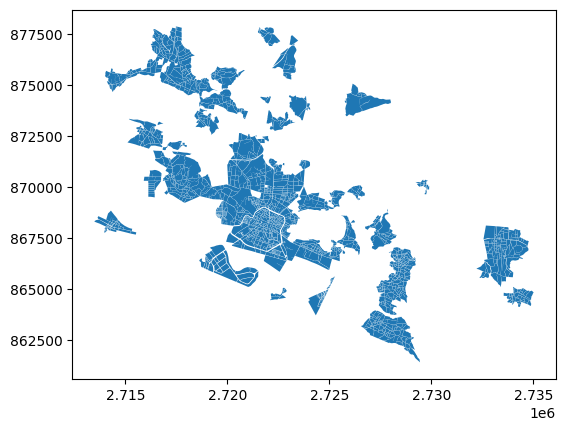

In [31]:
zona=zonas[zonas.CVE_MUN=='014']
zona.plot()


In [32]:
cruce_zona = gpd.sjoin(crucexpin,zona.to_crs(3857),how='left')
cruce_zona.rename(columns={'index_right':'ID_15m'},inplace=True)
cruce_zona.shape, crucexpin.shape

((55225, 29), (52372, 20))

In [33]:
cruce_zona.columns

Index(['clase_dete', 'conf', 'area', 'geometry', 'status', 'con_const',
       'CURT_f', 'ID_chin', 'conf_pin', 'area_pin', 'angulo', 'Clase',
       'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee',
       'ID_denue', 'PIN_si', 'ID_15m', 'CVEGEO', 'CVE_ENT', 'CVE_MUN',
       'CVE_LOC', 'CVE_AGEB', 'CVE_MZA', 'AMBITO', 'TIPOMZA'],
      dtype='object')

In [34]:
#Base de Areas verdes, camellones, glorietas
sia = gpd.read_file("/content/drive/MyDrive/Geo/Data/bases_shp_INEGI/bases_areasv_camellones/15sia.shp")
sia=sia.to_crs(3857)
#sia=sia[sia.CVE_MUN=='024']
sia.tail(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CONDICION,GEOGRAFICO,NOMSERV,TIPO,CVE_SERV,AMBITO,geometry
15162,151250007,15,125,0007,No Aplica,Camellón,Ninguno,Camellón,8,Urbana,"POLYGON ((-11028514.379 2234956.508, -11028465..."
15163,151250007,15,125,0007,No Aplica,Camellón,Ninguno,Camellón,1,Urbana,"POLYGON ((-11028099.917 2235050.154, -11028079..."


In [35]:
#Cruzar con ejes para quitar calles con overlay 
# Ejes de calles
ejes_path = "/content/drive/MyDrive/Geo/Data/DELEGACIONES_EDOMEX/ATLACOMULCO_2018/ATLACOMULCO/Ejes_Atlacomulco.shp"
ejes = gpd.read_file(ejes_path)
ejes = ejes.to_crs(3857)
ejes.tail(2)

,STREETS,BANDA,geometry
4078,SIN NOMBRE,NaN,"LINESTRING (-11118819.088 2251137.177, -111188..."
4079,LA HUERTA,NaN,"LINESTRING (-11118793.631 2248974.329, -111187..."


In [36]:
#Se revisa el CRS de cada base para poder hacer el cruce entre ellas
print("crs ejes: ",ejes.crs)
print("crs sia: ",sia.crs)

crs ejes:  EPSG:3857
crs sia:  EPSG:3857


In [37]:
cruce_ejes = sia.sjoin(ejes)
print(cruce_ejes.shape)
'Porcentaje a borrar: ',cruce_ejes.shape[0]/sia.shape[0]*100

(146, 14)


('Porcentaje a borrar: ', 0.9628066473226062)

In [38]:
import numpy as np 
print('Shape original: ', sia.shape)
index_drop = np.unique(sia[sia.geometry.isin(cruce_ejes.geometry)].index.values)
sia.drop(index=index_drop,inplace=True)
print('Shape final:    ', sia.shape)

Shape original:  (15164, 11)
Shape final:     (15110, 11)


In [39]:
cruce_zona.shape, sia.shape

((55225, 29), (15110, 11))

*Cruce de terrenos vs areas verdes (sia)*

In [40]:
cruce_final = gpd.sjoin(cruce_zona,sia,how='left')
cruce_final.tail(2)

,clase_dete,conf,area,geometry,status,con_const,CURT_f,ID_chin,conf_pin,area_pin,...,CVEGEO_right,CVE_ENT_right,CVE_MUN_right,CVE_LOC_right,CONDICION,GEOGRAFICO,NOMSERV,TIPO,CVE_SERV,AMBITO_right
26365,terreno_baldio,0.20002,782.179916,"POLYGON ((-11118878.968 2255709.957, -11118851...",correcto,0.0,19511342599952565529,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31275,terreno_baldio,0.20001,694.936771,"POLYGON ((-11112981.674 2243522.117, -11112966...",NaN,1.0,19450241899949459882,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Combinar las columnas que se duplican porque están en ambas bases y crear una general
cruce_final['CVEGEO']     =cruce_final.CVEGEO_left.combine_first(    cruce_final.CVEGEO_right)
cruce_final['CVE_ENT']    =cruce_final.CVE_ENT_left.combine_first(   cruce_final.CVE_ENT_right)
cruce_final['CVE_MUN']    =cruce_final.CVE_MUN_left.combine_first(   cruce_final.CVE_MUN_right)
cruce_final['CVE_LOC']    =cruce_final.CVE_LOC_left.combine_first(   cruce_final.CVE_LOC_right)
cruce_final['AMBITO']     =cruce_final.AMBITO_left.combine_first(    cruce_final.AMBITO_right)
cruce_final.rename(columns={'index_right':'ID_sia'},inplace=True)
#Eliminar las columnas divididas porque ya están en la general
cruce_final.drop(['CVEGEO_left','CVEGEO_right'],axis=1,inplace=True)
cruce_final.drop(['CVE_ENT_left','CVE_ENT_right'],axis=1,inplace=True)
cruce_final.drop(['CVE_MUN_left','CVE_MUN_right'],axis=1,inplace=True)
cruce_final.drop(['CVE_LOC_left','CVE_LOC_right'],axis=1,inplace=True)
cruce_final.drop(['AMBITO_left','AMBITO_right'],axis=1,inplace=True)

In [42]:
print('Columas de terrenos: ', cruce_final.columns)
if input('Quiere crear la columna ID_terreno') in ['1','si']:
    cruce_final.reset_index(drop=False, inplace=True)
    cruce_final.rename(columns={'index':'ID_terreno'},inplace=True)

Columas de terrenos:  Index(['clase_dete', 'conf', 'area', 'geometry', 'status', 'con_const',
       'CURT_f', 'ID_chin', 'conf_pin', 'area_pin', 'angulo', 'Clase',
       'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee',
       'ID_denue', 'PIN_si', 'ID_15m', 'CVE_AGEB', 'CVE_MZA', 'TIPOMZA',
       'ID_sia', 'CONDICION', 'GEOGRAFICO', 'NOMSERV', 'TIPO', 'CVE_SERV',
       'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'AMBITO'],
      dtype='object')
Quiere crear la columna ID_terreno1


In [43]:
cruce_final.columns

Index(['ID_terreno', 'clase_dete', 'conf', 'area', 'geometry', 'status',
       'con_const', 'CURT_f', 'ID_chin', 'conf_pin', 'area_pin', 'angulo',
       'Clase', 'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act',
       'clee', 'ID_denue', 'PIN_si', 'ID_15m', 'CVE_AGEB', 'CVE_MZA',
       'TIPOMZA', 'ID_sia', 'CONDICION', 'GEOGRAFICO', 'NOMSERV', 'TIPO',
       'CVE_SERV', 'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'AMBITO'],
      dtype='object')

In [44]:
try:
    cruce_final = cruce_final[['ID_terreno', 'clase_dete', 'Clase','geometry','CURT_f', 'status',
                               'conf', 'area', 'con_const',  'ID_chin', 'conf_pin', 'area_pin', 'angulo',
                               'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act',
                              'clee', 'ID_denue', 'PIN_si', 'ID_15m', 'CVE_AGEB', 'CVE_MZA',
                              'TIPOMZA', 'ID_sia', 'CONDICION', 'GEOGRAFICO', 'NOMSERV', 'TIPO',
                              'CVE_SERV', 'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'AMBITO']]
except:
    cruce_final = cruce_final[['ID_terreno', 'clase_dete', 'Clase','geometry','CURT_f', 'status',
                               'conf', 'area', 'con_const',  'ID_chin', 'conf_pin', 'area_pin', 'angulo',
                               'umbral', 'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act',
                              'clee', 'ID_denue', 'PIN_si', 'ID_15m', 'CVE_AGEB', 'CVE_MZA',
                              'TIPOMZA', 'ID_sia', 'CONDICION', 'GEOGRAFICO', 'NOMSERV', 'TIPO',
                              'CVE_SERV', 'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'AMBITO']]

In [45]:
cruce_final[cruce_final.ID_terreno.isna()]

,ID_terreno,clase_dete,Clase,geometry,CURT_f,status,conf,area,con_const,ID_chin,...,CONDICION,GEOGRAFICO,NOMSERV,TIPO,CVE_SERV,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,AMBITO


In [46]:
cruce_final.to_file('/content/drive/MyDrive/Cruces_predial_otros/Atlacomulco/Bases_salida_limpieza/terrenos/Atlacomulco_terrenos_cruces_todos.shp',
                 index=False)